# Deep Q Learning to Play Space Invaders

In [1]:
# Import packages
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque
import random
import time

from tensorflow.keras.models import Sequential
import tensorflow as tf
print(tf.__version__)

from skimage import transform 
from skimage.color import rgb2gray 

1.15.0


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17557304731791109610
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10207388889382360825
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11329617920
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14139883587247033655
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16360342389981201784
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## [1] Create the environment

In [4]:
# Create our environment
env = gym.make("SpaceInvaders-v0")

# Get state and action space
state_size = env.observation_space
action_size = env.action_space.n

print("The size of our frame is: ", state_size)
print("The action size is : ", action_size)

The size of our frame is:  Box(210, 160, 3)
The action size is :  6


## [2] Preprocess Functions

In [5]:
# plotting the images in a list
def plot_frames(display_list, title_list = None):
    
    plt.figure(figsize=(10, 10))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1) 
        
        if title_list:
            plt.title(title_list[i])
        plt.imshow(display_list[i])
        plt.axis('off')

    plt.show()

### [2.1] Image Filtering

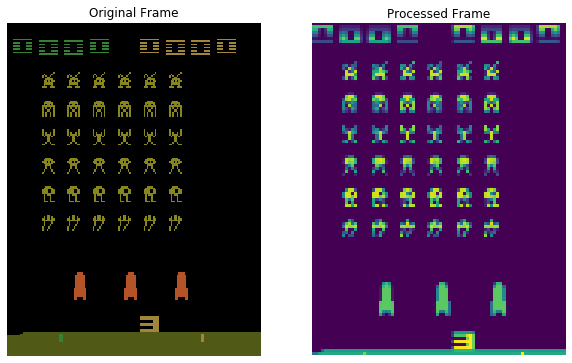

Size before process:  (210, 160, 3)
Size after process:  (110, 84)


In [6]:
# Normalise, turn into greyscale and crop image
frame_size = (110, 84)
def preprocess_frame(frame):
    # Greyscale frame 
    gray = rgb2gray(frame)
    
    # Crop the screen (remove the part below the player)
    # [Up: Down, Left: right]
    cropped_frame = gray[8:-12,4:-12]
    
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    
    # Resize
    # Thanks to Mikołaj Walkowiak
    preprocessed_frame = transform.resize(normalized_frame, frame_size)
    
    return preprocessed_frame # 110x84x1 frame

# Test out the preprocess procedure
sample_state = env.reset()
sample_state_processed = preprocess_frame(sample_state)
plot_frames([sample_state, sample_state_processed], ['Original Frame','Processed Frame'])

print('Size before process: ', sample_state.shape)
print('Size after process: ', sample_state_processed.shape)

### [2.2] Stack the frames

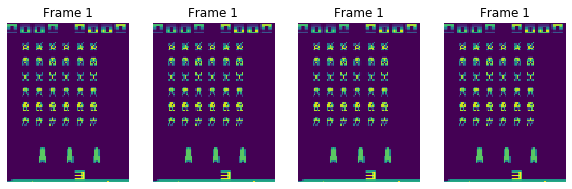

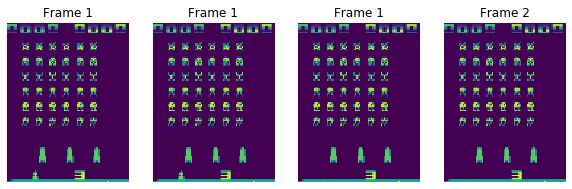

In [7]:
# Given a stacked frame, append a new frame to this stack
def stack_frames(stacked_frames, new_frame, is_new_episode):
    
    # Preprocess frame before stacking
    frame = preprocess_frame(new_frame)
    
    # if new episode make copies of frame, else append frame
    if is_new_episode:
        
        # Clear stacked frames
        stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)
        
        # Append the same frame to the stack stack_size times
        for _ in range(0, stack_size):
            stacked_frames.append(frame)
        
        # Return a numpy array for the stacked frame
        stacked_states = np.stack(stacked_frames, axis = 2)
    
    else:
        stacked_frames.append(frame)
        stacked_states = np.stack(stacked_frames, axis = 2)
    
    return stacked_states, stacked_frames

# Stacking frames to provide input = [frame 1, frame 2, frame 3, frame 4]
stack_size = 4

# Initialise with array of zeros
stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)

# Test out the stack_frames procedure
sample_state = env.reset()
stacked_states, stacked_frames = stack_frames(stacked_frames, sample_state, True)
plot_frames(stacked_frames, ['Frame ' + str(1) for i in range(0,4)])

for i in range(0, 4):
    sample_next_state, _ , done , _  = env.step(env.action_space.sample())
    stacked_states, stacked_frames = stack_frames(stacked_frames, sample_next_state, False)
    
plot_frames(stacked_frames, ['Frame ' + str(1) for i in range(1,4)] + ['Frame 2'] )

## 3 Training 

In [17]:
# Define paramters for training 
LEARNING_RATE = 0.001
MEMORY_SIZE = 100000
BATCH_SIZE = 64
MAX_STEP = 50000
UPDATE_MODEL_STEP = 5000

EXPLORATION_RATE = 1
EXPLORATION_DECAY = 0.9999
EXPLORATION_MIN = 0.01

GAMMA = 0.9

### [3.1] Create Deep Q Neural Network

In [9]:
class DQNetworks:
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        with tf.variable_scope(name):
            # We create the placeholders
            # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
            # [None, 84, 84, 4]
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.float32, [None, self.action_size], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            # Input the Importance sampling weights here
            self.IS_weights = tf.placeholder(tf.float32, [None], name="IS_weights")
            
            """
            First convnet:
            CNN
            ELU
            """
            # Input is 110x84x4
            self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                         filters = 32,
                                         kernel_size = [8,8],
                                         strides = [4,4],
                                         padding = "VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         name = "conv1")
            
            self.conv1_out = tf.nn.elu(self.conv1, name="conv1_out")
            
            """
            Second convnet:
            CNN
            ELU
            """
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                 filters = 64,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv2")

            self.conv2_out = tf.nn.elu(self.conv2, name="conv2_out")            
            
            """
            Third convnet:
            CNN
            ELU
            """
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                 filters = 64,
                                 kernel_size = [3,3],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv3")

            self.conv3_out = tf.nn.elu(self.conv3, name="conv3_out")
            
            self.flatten = tf.contrib.layers.flatten(self.conv3_out)
            
            ## Here to separate into two streams
            # The one to calculate V(s)
            self.value_fc = tf.layers.dense(inputs = self.flatten,
                                            units = 512,
                                            activation = tf.nn.elu,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                            name="value_fc")
            
            self.value =  tf.layers.dense(inputs = self.value_fc,
                                          units = 1,
                                          activation = None,
                                          kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          name="value")
            
            # The one to calculate A(s,a)
            self.advantage_fc = tf.layers.dense(inputs = self.flatten,
                                                units = 512,
                                                activation = tf.nn.elu,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                                name="advantage_fc")
            
            self.advantage = tf.layers.dense(inputs = self.advantage_fc, 
                                             kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                             units = self.action_size, 
                                             activation=None,
                                             name = "advantage")
            
            
            # Agregating layer 
            self.output = tf.add(self.value, tf.subtract(self.advantage, tf.reduce_mean(self.advantage, axis=1, keepdims=True)))
              
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_), axis = -1)
            
            # Absolute errors for Priortising
            self.abs_TD_error = tf.abs(self.target_Q - self.Q)
            
            # The loss is the difference between our predicted Q_values and the Q_target
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(self.IS_weights * tf.square(self.abs_TD_error))
            
            self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)

In [10]:
# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DQNetworks([110, 84, 4], action_size, LEARNING_RATE, "DQN")

# Instantiate the TargetDQNetwork
TargetDQNetwork = DQNetworks([110, 84, 4], action_size, LEARNING_RATE, "TargetDQN")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### [3.2] Create memory for experience relay

In [11]:
class SumTree:
    
    # Index for pointing to data 
    data_index = 0
    capacity_filled = 0
    
    # Initialise the tree and data
    def __init__(self, capacity):
        
        # The size of the leaves
        self.capacity = capacity
        
        # Define the tree list itself, zeros everywhere
        self.tree = np.zeros(capacity*2 - 1)
        
        # Define the data list for holding experiences, zeros everywhere
        self.data = np.zeros(capacity, dtype=object)
        
    # Add new values to tree
    def add(self, priority, data):
        
        # add to data list 
        self.data[self.data_index] = data
        
        # add the priority to the leaf of the tree
        tree_index = self.data_index + self.capacity - 1
        self.update(priority, tree_index)
        
        # Increase data_index
        self.data_index += 1
        if self.data_index > self.capacity - 1:
            self.data_index = 0
            
        # Inrease capacity filled
        if self.capacity_filled < self.capacity:
            self.capacity_filled += 1
            
    # Update all the nodes leading up to a leaf
    def update(self, priority, tree_index):
        
        # Find the change in priority value
        delta_priority = priority - self.tree[tree_index]
        
        # Update leaf
        self.tree[tree_index] = priority
        
        # Propagate change up
        while tree_index != 0 :
            tree_index = (tree_index - 1)//2
            self.tree[tree_index] += delta_priority 
            
    # sample a leaf from a value
    def get_leaf(self, value):
        
        # Define initial indixes
        parent_index = 0
        left_index = 1
        right_index = 2
        
        # Retrive the leaf algorithm
        while left_index < (2*self.capacity - 1):
            if self.tree[left_index] >= value: 
                parent_index = left_index
            else:
                parent_index = right_index
                value = value - self.tree[left_index]      
            # Update left_index for next iteration
            left_index = parent_index*2 + 1
            right_index = left_index + 1
            
        return parent_index, self.tree[parent_index], self.data[parent_index + 1 - self.capacity]

In [30]:
class Memory():
    
    # Max TD error
    abs_error_upper = 1.0;
    
    # Prioritzation exponents
    PER_a = 0.6
    PER_b = 0.4
    epsilon= 0.01
    
    # Incremental value for PER_b
    PER_b_increments = 0.001
    
    def __init__(self, capacity):
        
        # Create the sum tree
        self.memory_tree = SumTree(capacity)
            
    def store(self, experience):
        
        # Get the max priority so far
        max_priority = np.max(self.memory_tree.tree[-self.memory_tree.capacity:])
        
        # if max prioity is 0 then set it as abs_error_upper
        if max_priority == 0:
            max_priority = self.abs_error_upper
        
        # Store this experience in the tree
        self.memory_tree.add(max_priority, experience)
        
        
    def sample(self, n):
        
        # Get total priority
        total_priority = self.memory_tree.tree[0]
        
        # Sample from a mini range [0:total_priority] in batch sizes
        sample_ranges = np.linspace(0, total_priority, num=n+1)
        
        # get min P(i) of data filled so far and max weight to scale maximum weights = 1
        start_filled = -self.memory_tree.capacity
        end_filled = -(self.memory_tree.capacity - self.memory_tree.capacity_filled)
        if  end_filled == 0:
            min_probability = np.min(self.memory_tree.tree[start_filled:])/total_priority
        else:
            min_probability = np.min(self.memory_tree.tree[start_filled:end_filled])/total_priority
        max_weight = (self.memory_tree.capacity_filled * min_probability) ** (-self.PER_b)
        
        # Initialise list for storing
        tree_indexes = np.empty(n, dtype=np.int32)
        IS_weights = np.empty(n, dtype=np.float32)
        batch = []
        
        # Sample in a loop
        for i in range(0, n):
            value = np.random.uniform(sample_ranges[i], sample_ranges[i+1])
            tree_index, priority, experience = self.memory_tree.get_leaf(value)
            
            # Append tree indicies of sample 
            tree_indexes[i] = tree_index
            
            # Obtain IS_weights
            sample_probability = (priority / total_priority)
            IS_weights[i] = ((self.memory_tree.capacity_filled * sample_probability) ** (-self.PER_b)) / max_weight
            
            # append expereice  to batch
            batch.append(experience)
            
        # Increase PER_b value for every sampling action max = 1
        if self.PER_b < 1.0:
            self.PER_b += self.PER_b_increments
        
        return tree_indexes, IS_weights, batch
            
            
    def update_batch(self, tree_indexes, TD_errors):
        priorities = np.minimum(self.abs_error_upper, (TD_errors + self.epsilon)) ** self.PER_a
        
        # update the batch of prrioties
        for idx, new_p in zip(tree_indexes, priorities):
            self.memory_tree.update(new_p, idx)

In [176]:
start_filled = -memory.memory_tree.capacity 
end_filled = -(memory.memory_tree.capacity - memory.memory_tree.capacity_filled) 
memory.memory_tree.tree[start_filled:end_filled]

array([1.        , 1.        , 1.        , 0.06473273, 0.06612306,
       1.        , 1.        , 0.06399166, 1.        , 1.        ,
       1.        , 0.06318223, 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.06552009, 0.06575353, 1.        ,
       1.        , 1.        , 0.06333977, 1.        , 0.06717559,
       0.06318223, 1.        , 1.        , 1.        , 0.06386025,
       0.06333977, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.06637347, 0.06552009, 1.        , 1.        ,
       1.        , 0.06575353, 1.        , 1.        , 0.063321  ,
       1.        , 1.        , 0.06630511, 0.06383928, 1.        ,
       1.        , 1.        , 0.06536387, 1.        , 1.        ,
       1.        , 0.06683905, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.06545214, 0.06346885,
       1.        , 1.        , 1.        , 1.        , 0.06661084,
       1.        , 1.        , 0.06550597, 0.06440443, 1.     

In [122]:
memory.memory_tree.tree[0]

563.0

### [3.3] Act to exploit or explore

In [13]:
# Function to pick action either from model or take random action
def act(state, exploration_rate):
    
    # Take random action
    if np.random.rand() < exploration_rate:
        return env.action_space.sample()
    
    # Else use the model to predict a action
    q_values = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state[tf.newaxis,...]})
    
    return np.argmax(q_values[0])

In [14]:
# Update the target network 
def update_graph():
    
    # Get weights
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "DQN")
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "TargetDQN")
    
    # Update the target 
    updated_weights = [to_var.assign(from_var) for from_var, to_var in zip(from_vars, to_vars)]
    
    return updated_weights

## [3.4] Train agent in batches from memory

In [15]:
# Function to fit data from experience obtained from memory, THE LEARNING PROCEDURE
def model_fit(BATCH_SIZE):
    
    # Sample from memory
    tree_idx, IS_weights, batch = memory.sample(BATCH_SIZE)

    # Initialise list of target Q and states
    target_Q = []
    state_train = []
    action_list = []
    
    # Extract each parameter from batch
    for state, action, reward, state_next, done in batch:

        # add states to list
        state_train.append(state)
        
        # add action to list
        action_onehot = np.zeros(action_size)
        action_onehot[action] = 1
        action_list.append(action_onehot)

        # Add the target Q to list
        if done:
            target_Q.append(reward)
        else:
            # Double target DQN, take best action from DQN and update with Q-values with TargetDQN Q-values[best_action]
            best_action = np.argmax(sess.run(DQNetwork.output, 
                                            feed_dict = {DQNetwork.inputs_: state_next[tf.newaxis,...]})[0])
            Q_update = reward + GAMMA * sess.run(TargetDQNetwork.output, 
                                                feed_dict = {TargetDQNetwork.inputs_: state_next[tf.newaxis,...]})[0][best_action]
            target_Q.append(Q_update)

    # Turn states and target Q in numpy arrays
    state_train = np.array(state_train)
    target_Q = np.array(target_Q)
    action_list = np.array(action_list)
    
    # Fit the data 
    loss, abs_TD_error, _ = sess.run([DQNetwork.loss, DQNetwork.abs_TD_error, DQNetwork.optimizer],
                                            feed_dict={DQNetwork.inputs_: state_train,
                                                    DQNetwork.target_Q: target_Q,
                                                    DQNetwork.actions_: action_list,
                                                    DQNetwork.IS_weights: IS_weights})
    # Update the priorites with latest TD errors
    memory.update_batch(tree_idx, abs_TD_error)
    
    return loss

### [3.5] Test agent by taking random actions

In [16]:
# Play a game to test environment 
def test(n_episodes, model = None, memory = None):
    
    # Initialise average rewards
    avg_rewards = 0
    run_list = []
    
    for i in range(1, n_episodes+1):
        
        # Initialise the start of environment
        state = env.reset()
        stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        done = False 
        total_reward = 0
        steps = 0

        while not done:
            if model:
                action = np.argmax(sess.run(model.output, feed_dict = {model.inputs_: state[tf.newaxis,...]})[0])
            else:
                action = env.action_space.sample()
            state_next, reward, done, info = env.step(action)
            state_next, stacked_frames = stack_frames(stacked_frames, state_next, False)
            if memory:
                memory.store((state, action, reward, state_next, done))
            state = state_next
            total_reward += reward
            steps += 1
            if steps > MAX_STEP:
                done = True
        
        avg_rewards = avg_rewards + 1/(i) * (total_reward - avg_rewards)
        run_list.append(steps)
        
    return run_list, avg_rewards

In [31]:
# Initialise memory
memory = Memory(200)

# Run Tests
steps, total_reward = test(1, model = None, memory = memory)

print("Total steps by taking random actions: ", steps)
print("Average rewards by taking random actions: ", total_reward)
print("Memory length: ", memory.memory_tree.capacity_filled)

Total steps by taking random actions:  [1119]
Average rewards by taking random actions:  255.0
Memory length:  200


In [184]:
tree_idx, IS_weights, batch = memory.sample(BATCH_SIZE)

print(IS_weights)

[0.3194578 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578
 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578
 0.3194578 0.3194578 0.3194578 0.3194578 0.9849532 0.3194578 0.3194578
 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578
 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578
 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578 0.9916156 0.3194578
 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578
 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578
 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578 0.3194578
 0.3194578]


In [186]:
memory.memory_tree.tree[tree_idx]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.06545993, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.06440011, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

In [194]:
batch[0][1]

5

In [100]:
# Define the training material
state_train = np.random.rand(2,110, 84, 4)
target_Q = np.random.rand(2)
action_list = np.array([[0,1,0,0,0,0], [0,0,0,0,1,0]])
IS_weights = np.array([0.1, 0.1])

with tf.Session() as sess:
    
    # Initialize the variables
    sess.run(tf.global_variables_initializer())
    
    loss, abs_error, weighted_TD = sess.run([DQNetwork.loss, DQNetwork.abs_TD_error, DQNetwork.weighted_TD], 
                                    feed_dict = {DQNetwork.inputs_: stacked_states[tf.newaxis,...], 
                                                 DQNetwork.target_Q: target_Q,
                                                 DQNetwork.actions_: action_list,
                                                 DQNetwork.IS_weights: IS_weights})


print(loss)
print(abs_error)
print(weighted_TD)

0.010286483
[0.11516771 0.43870953]
[0.01151677 0.04387095]


In [22]:
# Check time taken to train for 1 batch
start_time = time.time()
with tf.Session() as sess:
    # Initialize the variables
    sess.run(tf.global_variables_initializer())
    history = model_fit(BATCH_SIZE)
print("Loss is :", history)
print("Elapsed_time: ", time.time() - start_time)

Loss is : 2.551473
Elapsed_time:  0.5619301795959473


### Training on the environment

In [18]:
# Saver will help us to save our model
saver = tf.train.Saver()

# Re-Initialise memory for training
memory = Memory(MEMORY_SIZE)

# Store measurements
loss = []
reward_list = []
step_list = []
total_steps = 0
start_time = time.time()

with tf.Session() as sess:
    
    # Initialize the variables
    sess.run(tf.global_variables_initializer())
     
    # Number of episodes to train 
    N = 150 
    for i in range(0, N):

        # Initialise state
        state = env.reset()
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        reward_sum = 0

        # Initialise step oer episode
        step = 0
        done = False

        while not done:

            # Get action 
            action = act(state, EXPLORATION_RATE)

            # Take action
            state_next, reward, done, _ = env.step(action)

            # stops the episode by set max step
            if step > MAX_STEP:
                done = True
                print("Episode Done")

            # Append the next state
            state_next, stacked_frames = stack_frames(stacked_frames, state_next, False)

            # Append to memory
            memory.store((state, action, reward, state_next, done))

            # Forward to next state
            state = state_next

            # accumulate rewards
            reward_sum += reward
            
            # Update model every UPDATE_STEP (5000)
            if total_steps % UPDATE_MODEL_STEP == 0:
                sess.run(update_graph())
                print("Target network updated!")

            # accumilate steps
            step += 1
            total_steps += 1

            # Reduce the exploreation every step
            EXPLORATION_RATE *= EXPLORATION_DECAY
            EXPLORATION_RATE = max(EXPLORATION_MIN, EXPLORATION_RATE)

            ### Learning procedure begins ###
            # learn only when memory has be filled to batch size
            if memory.memory_tree.capacity_filled >= BATCH_SIZE:
                history = model_fit(BATCH_SIZE)

                # store loss
                loss.append(history)
            ### Learning procedure ends ###

            # Print messge every 100 episodes
#             if total_steps % 100 == 0:
#                 print("Afte {} steps, exploration rate: {:.4f}, reward: {}, Model loss: {:.4f}"\
#                       .format(total_steps, EXPLORATION_RATE, reward_sum, history))
                

        # Append values at the end of an episode
        step_list.append(step)
        reward_list.append(reward_sum)

        # print information at the end of the episode
        print("Episode {}, exploration rate: {:.4f}, final rewards: {}, final loss is {:.4f}, Time elapsed: {:.4f}"\
              .format(i+1, EXPLORATION_RATE, reward_sum, history, time.time() - start_time))
        start_time = time.time()
        
    save_path = saver.save(sess, "./D3QN_PER_models/model.ckpt")
    print("Model Saved")

Target network updated!
Episode 1, exploration rate: 0.9317, final rewards: 110.0, final loss is 0.5310, Time elapsed: 224.4139
Episode 2, exploration rate: 0.8873, final rewards: 50.0, final loss is 0.6487, Time elapsed: 101.8743
Episode 3, exploration rate: 0.8282, final rewards: 185.0, final loss is 0.2043, Time elapsed: 142.7031
Episode 4, exploration rate: 0.7876, final rewards: 30.0, final loss is 0.1128, Time elapsed: 104.5487
Episode 5, exploration rate: 0.7309, final rewards: 180.0, final loss is 0.2216, Time elapsed: 155.1433
Episode 6, exploration rate: 0.6890, final rewards: 110.0, final loss is 0.5988, Time elapsed: 122.8135
Episode 7, exploration rate: 0.6440, final rewards: 120.0, final loss is 0.1494, Time elapsed: 140.3883
Target network updated!
Episode 8, exploration rate: 0.5940, final rewards: 125.0, final loss is 0.2199, Time elapsed: 168.4722
Episode 9, exploration rate: 0.5436, final rewards: 225.0, final loss is 0.3648, Time elapsed: 186.7073
Episode 10, explor

Episode 77, exploration rate: 0.0100, final rewards: 85.0, final loss is 0.2517, Time elapsed: 132.8893
Episode 78, exploration rate: 0.0100, final rewards: 245.0, final loss is 0.1554, Time elapsed: 180.0562
Episode 79, exploration rate: 0.0100, final rewards: 210.0, final loss is 0.5626, Time elapsed: 144.8498
Episode 80, exploration rate: 0.0100, final rewards: 245.0, final loss is 0.1741, Time elapsed: 252.2702
Episode 81, exploration rate: 0.0100, final rewards: 255.0, final loss is 0.8396, Time elapsed: 212.1509
Target network updated!
Episode 82, exploration rate: 0.0100, final rewards: 55.0, final loss is 0.8206, Time elapsed: 105.7779
Episode 83, exploration rate: 0.0100, final rewards: 80.0, final loss is 0.1727, Time elapsed: 94.0028
Episode 84, exploration rate: 0.0100, final rewards: 60.0, final loss is 0.3307, Time elapsed: 76.8151
Episode 85, exploration rate: 0.0100, final rewards: 60.0, final loss is 0.4525, Time elapsed: 132.5817
Episode 86, exploration rate: 0.0100, 

ValueError: zero-size array to reduction operation minimum which has no identity

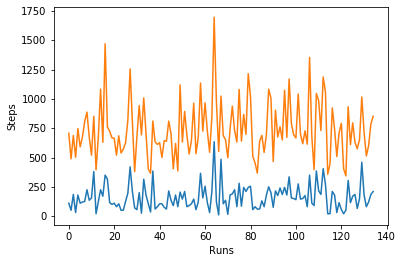

In [20]:
# plot result
plt.plot(reward_list)
plt.ylabel('Steps')
plt.xlabel('Runs')


plt.plot(step_list)
plt.ylabel('Steps')
plt.xlabel('Runs')

plt.show()

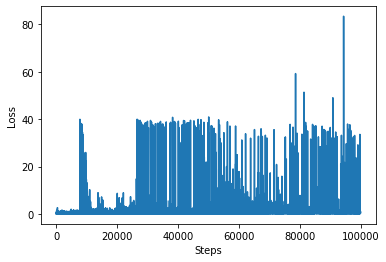

In [21]:
# plot loss
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('Steps')
plt.show()

In [19]:
# Number of steps learnt
memory.memory_tree.capacity_filled

100000

In [ ]:
# For saving and loading files
saver = tf.train.Saver()

In [25]:
# Test the model and get average rewards
with tf.Session() as sess:
    
    # Load the model
    saver.restore(sess, "./D3QN_PER_models/model.ckpt")
    
    # Run Tests
    N_tests = 20
    steps, total_reward = test(N_tests, model = DQNetwork, memory = None)
    
print("Average rewards over {} episodes is {}".format(N_tests, total_reward))

INFO:tensorflow:Restoring parameters from ./D3QN_PER_models/model.ckpt
Average rewards over 20 episodes is 175.49999999999997


In [19]:
with tf.Session() as sess:
    
    # Load the model
    saver.restore(sess, "./D3QN_PER_models/model.ckpt")
    
    Q_DQN = sess.run(DQNetwork.output, 
                                    feed_dict = {DQNetwork.inputs_: stacked_states[tf.newaxis,...]})[0]
    print(Q_DQN)
    
    # Initialise environment 
    state = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, state, True)

    done = False 
    total_reward = 0
    steps = 0

    # Until done 
    while not done:

        # render the current environment 
        env.render()

        # take an action using model
        Q_values= sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state[tf.newaxis,...]})
        action = np.argmax(Q_values[0])
        next_state, reward, done, info = env.step(action)
        next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
        state = next_state

        total_reward += reward
        steps += 1

        # pause for visualisation
        time.sleep(0.01)

    env.close()
    print ("Score: {}, Steps: {}".format(total_reward, steps))

INFO:tensorflow:Restoring parameters from ./D3QN_PER_models/model.ckpt
[-0.32561296 -0.4426517  -1.150526   -0.5496196  -0.89415544 -0.6408557 ]
Score: 225.0, Steps: 856
